{/* cspell:ignore mactex, backgroundcolor, lightgreen */}

# Visualize circuit timing

In addition to [visualizing instructions on a circuit](/docs/guides/visualize-circuits) you might want to use the Qiskit [`timeline_drawer`](/docs/api/qiskit/qiskit.visualization.timeline_drawer) method, which lets you visualize a circuit's scheduling. This visualization could help you to quickly spot idling time on qubits, for example.

<Admonition type="note" title="Notes">
- This is an experimental function. It is in preview release status and is therefore subject to change.
- This function only applies to Qiskit Runtime Sampler jobs.
</Admonition>

## Examples

To visualize a scheduled circuit program, you can call this function with a set of control arguments. Most of the  output image's appearance can be modified by a stylesheet, but this is not required.

### Draw with the default stylesheet

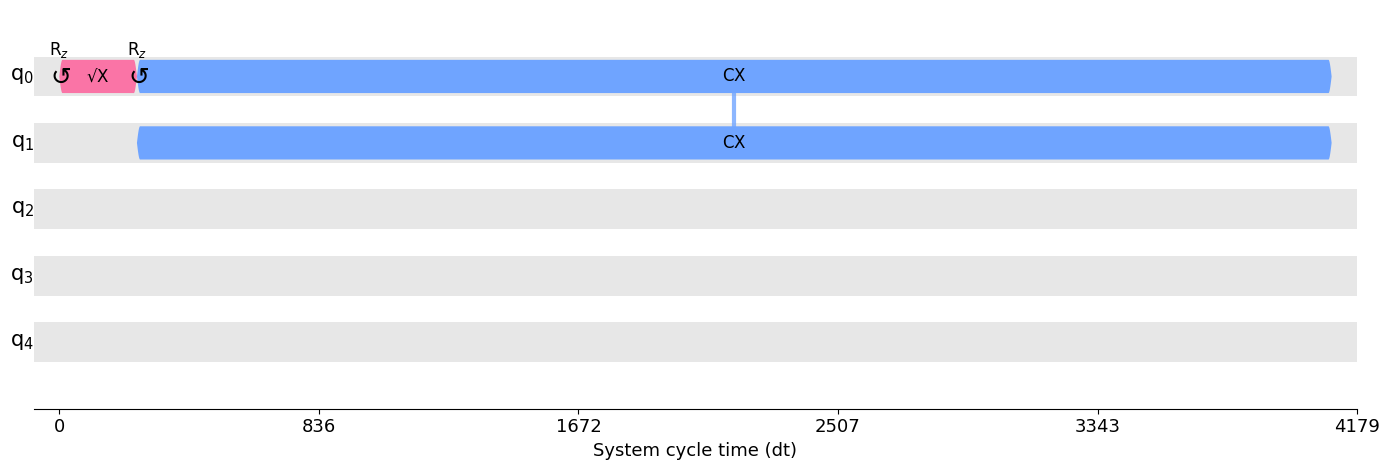

In [1]:
from qiskit import QuantumCircuit
from qiskit.visualization.timeline import draw
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import generate_preset_pass_manager

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

backend = GenericBackendV2(5)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

draw(isa_circuit, target=backend.target)

### Draw with a stylesheet suited for program debugging

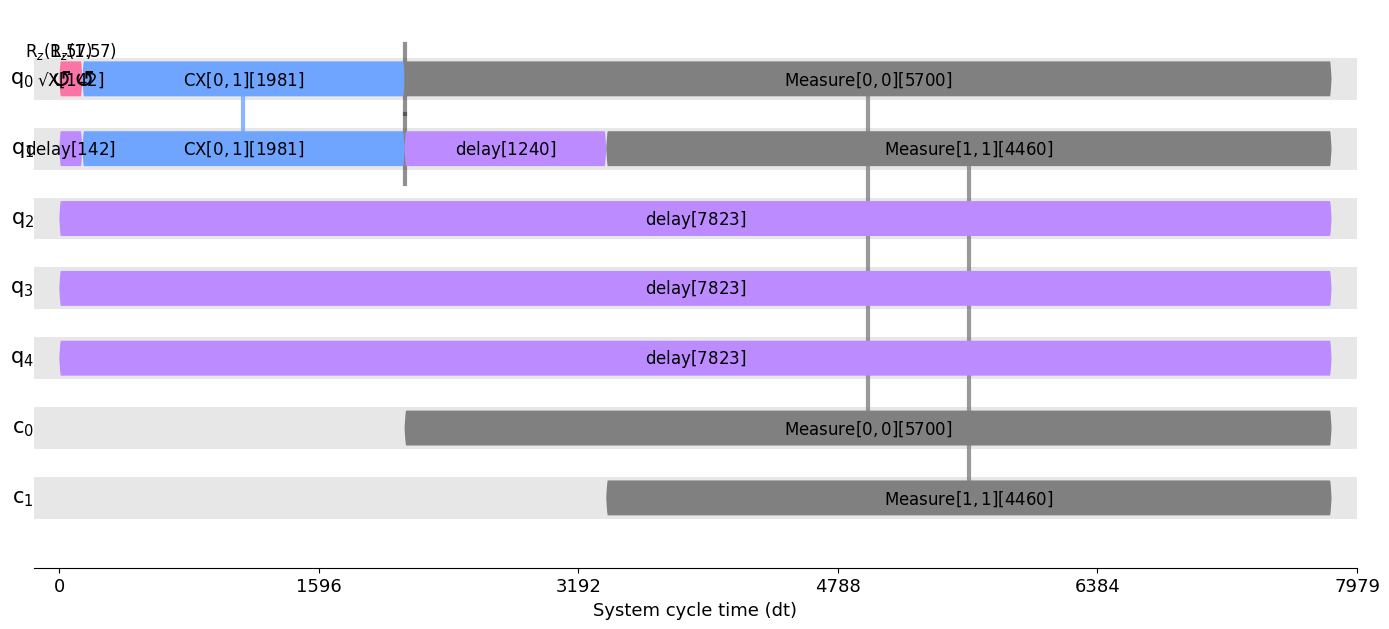

In [2]:
from qiskit import QuantumCircuit
from qiskit.visualization.timeline import draw, IQXDebugging
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import generate_preset_pass_manager

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

backend = GenericBackendV2(5)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
draw(isa_circuit, style=IQXDebugging(), target=backend.target)

You can create custom generator or layout functions and update an existing stylesheet with the custom functions. This way, you can control the most of the appearance of the output image without modifying the codebase of the scheduled circuit drawer.  See the [`timeline_drawer`](/docs/api/qiskit/qiskit.visualization.timeline_drawer) API reference for more examples.

## Qiskit Runtime support

While the timeline drawer built in to Qiskit is useful for static circuits, it might not accurately reflect the timing of [dynamic circuits](/docs/guides/classical-feedforward-and-control-flow) because of implicit operations such as broadcasting and branch determination. As part of dynamic circuit support, Qiskit Runtime returns the accurate circuit timing information inside the job results when requested.

### Enable timing data retrieval

To enable timing data retrieval, set the experimental `scheduler_timing` flag to `True` when running the primitive job.

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

sampler = SamplerV2(backend)
sampler.options.experimental = {
    "execution": {
        "scheduler_timing": True,
    },
}

sampler_job = sampler.run([isa_circuit])
result = sampler_job.result()

management.get:WARNING:2025-10-20 12:31:57,331: Loading default saved account
qiskit_runtime_service.__init__:WARNING:2025-10-20 12:32:05,740: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (internal, premium), the available account instances are: Documentation premium fleet, Documentation internal fleet, Documentation premium fleet, Documentation internal fleet. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-10-20 12:32:07,039: Loading instance: Documentation premium fleet, plan: premium
qiskit_runtime_service.backends:WARNING:2025-10-20 12:32:08,525: Loading instance: Documentation internal fleet, plan: internal
qiskit_runtime_service.backends:WARNING:2025-10-20 12:32:09,185: Loading 

### Access the circuit timing data

When requested, the circuit timing data is returned in the job result metadata, under `["compilation"]["scheduler_timing"]["timing"]`. This field contains the raw timing information. To display the timing information, use the built-in visualization tool to display it, as described in the following section.

Use the following code to access the circuit timing data:

In [4]:
job_result = sampler_job.result()
circuit_schedule = job_result[0].metadata["compilation"]["scheduler_timing"]
circuit_schedule_timing = circuit_schedule["timing"]

#### Understand the raw timing data

While visualizing the circuit timing data by using the `draw_circuit_schedule_timing` method is the most common use case, it might be useful to understand the structure of the raw timing data returned. This could help you, for example, to extract information programmatically.

The timing data returned in `["compilation"]["scheduler_timing"]["timing"]` is a list of strings. Each string represents a single instruction on some channel and is comma separated into the following data types:

- `Branch` - Determines whether the instruction is in a control flow (then / else) or a main branch
- `Instruction` - The gate and the qubit to operate on
- `Channel` - The channel that is being assigned with the instruction. It can be one of the following:\n",
      - `Qubit x` is the drive channel for qubit _x_.\n",
      - `AWGRx_y` (arbitrary waveform generator readout) is used for readout channels communication for measuring qubits. The _x_ and _y_ arguments correspond to the readout instrument ID and the qubit number, respectively.
- `T0` - The instruction start time within the complete schedule
- `Duration` - The instruction's duration
- `Pulse` - The type of pulse operation being used


Example:

```python
main,barrier,Qubit 0,7,0,barrier # A barrier on the main branch on qubit 0 at time 7 with 0 duration
main,reset_0,Qubit 0,7,64,play # A reset instruction on the main branch on qubit 0 at time 7 with duration 64 and a play operation
...
```

### Visualize the timings

With `qiskit-ibm-runtime` v0.43.0 or later, you can visualize circuit timings. To visualize the timings, you first need to convert the result metadata to `fig` by using the `draw_circuit_schedule_timing` (**link to API reference when available**) method. This method returns a `plotly` figure, which you can display directly, save to a file, or both.  For more information about the `plotly` commands to use, see [`fig.show()`](https://plotly.com/python-api-reference/generated/plotly.io.show.html) and  [`fig.write_image("<path.format>")`.](https://plotly.com/python-api-reference/generated/plotly.io.write_image.html)

In [5]:
from qiskit_ibm_runtime.visualization import draw_circuit_schedule_timing

# Create a figure from the metadata
fig = draw_circuit_schedule_timing(
    circuit_schedule=circuit_schedule_timing,
    included_channels=None,
    filter_readout_channels=False,
    filter_barriers=False,
    width=1000,
)

# Display the figure
fig.show()

# Save to a file
# fig.write_html("scheduler_timing.html")

#### Understand the generated figure

The image of the circuit timing data output by `draw_circuit_schedule_timing` conveys the following information:

- X axis is time in units of _dt_ seconds,  where 1 dt = 1 scheduling cycle.
- Y axis is the channel (think of channels as instruments that emit pulses).
    - `Receive channel` is the only channel that isn't an instrument by itself. It is an instruction played on all channels that are part of a communication procedure with the hub at that time.
    - `Qubit x` is the drive channel for qubit x.
    - `AWGRx_y` (arbitrary waveform generator readout) is used for readout channels communication for measuring qubits. The x and y arguments correspond to the readout instrument ID and the qubit number, respectively.
    - `Hub` controls broadcasting.

Additionally, each instruction has the format of *X_Y*, where *X* is the name of the instruction and *Y* is the pulse type. A `play` type applies control pulses, and a `capture` records the qubit's state. You can also hover over each instruction to get more details. For example, the following figure shows a control pulse for the X gate applied to qubit 10 at 1161 dt:

![Hovering over the output shows information such as the start, finish, and duration.](/docs/images/guides/visualize-circuit-timing/hover.svg 'Hovering over the figure for more details')

### End-to-end example

This example shows you how to enable the option, get it from the metadata, display it, and save it to a file.

First, set up the environment, define the circuits and convert them to ISA circuits, and define and run the jobs.

In [6]:
from qiskit_ibm_runtime import SamplerV2
from qiskit.circuit import QuantumCircuit

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

# Create a Bell circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

qc.draw()

# Convert to an ISA circuit for the given backend

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

# Generate samplers for backend targets
sampler = SamplerV2(backend)
sampler.options.experimental = {"execution": {"scheduler_timing": True}}

# Submit jobs
sampler_job = sampler.run([isa_circuit])

print(
    f">>> {' Job ID:':<10}  {sampler_job.job_id()} ({sampler_job.status()})"
)

management.get:WARNING:2025-10-20 12:32:22,821: Loading default saved account
qiskit_runtime_service.__init__:WARNING:2025-10-20 12:32:31,261: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (internal, premium), the available account instances are: Documentation premium fleet, Documentation internal fleet, Documentation premium fleet, Documentation internal fleet. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-10-20 12:32:32,643: Loading instance: Documentation premium fleet, plan: premium
qiskit_runtime_service.backends:WARNING:2025-10-20 12:32:34,213: Loading instance: Documentation internal fleet, plan: internal
qiskit_runtime_service.backends:WARNING:2025-10-20 12:32:34,869: Loading 

>>>  Job ID:    d3r74f3grqts73862cv0 (QUEUED)


Next, get the circuit schedule timing:

In [7]:
# Get the circuit schedule timing
result[0].metadata["compilation"]["scheduler_timing"]["timing"]

'main,barrier,Qubit 0,0,0,barrier\nmain,barrier,Qubit 1,0,0,barrier\nmain,INIT_0,Qubit 0,10,2500,play\nmain,INIT_0,Qubit 0,9,2500,play\nmain,INIT_1,Qubit 1,10,2500,play\nmain,INIT_1,Qubit 1,9,2500,play\nmain,barrier,Qubit 0,2510,0,barrier\nmain,barrier,Qubit 1,2510,0,barrier\nmain,rz_0,Qubit 73,2510,0,shift_phase\nmain,rz_0,Qubit 0,2510,0,shift_phase\nmain,rz_0,Qubit 49,2510,0,shift_phase\nmain,sx_0,Qubit 0,2510,256,play\nmain,rz_0,Qubit 73,2766,0,shift_phase\nmain,rz_0,Qubit 0,2766,0,shift_phase\nmain,rz_0,Qubit 49,2766,0,shift_phase\nmain,rz_1,Qubit 1,2510,0,shift_phase\nmain,rz_1,Qubit 73,2510,0,shift_phase\nmain,rz_1,Qubit 74,2510,0,shift_phase\nmain,sx_1,Qubit 1,2510,256,play\nmain,rz_1,Qubit 1,2766,0,shift_phase\nmain,rz_1,Qubit 73,2766,0,shift_phase\nmain,rz_1,Qubit 74,2766,0,shift_phase\nmain,cz_0_1,Qubit 0,2766,21,play\nmain,cz_0_1,Qubit 1,2766,21,play\nmain,rz_1,Qubit 1,2787,0,shift_phase\nmain,rz_1,Qubit 73,2787,0,shift_phase\nmain,rz_1,Qubit 74,2787,0,shift_phase\nmain,sx_1

Finally, you can visualize and save the timing:

In [8]:
from qiskit_ibm_runtime.visualization import draw_circuit_schedule_timing

circuit_schedule = result[0].metadata["compilation"]["scheduler_timing"][
    "timing"
]
fig = draw_circuit_schedule_timing(
    circuit_schedule=circuit_schedule,
    included_channels=None,
    filter_readout_channels=False,
    filter_barriers=False,
    width=1000,
)

# Display the figure
fig.show()

## Next steps

<Admonition type="tip" title="Recommendations">
  - [Classical feedforward and control flow](/docs/guides/classical-feedforward-and-control-flow) (dynamic circuits)
  - [Visualize circuits](/docs/guides/visualize-circuits)
</Admonition>